In [1]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import pandas as pd
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
DATA_ROOT = "/scratch/attiqrehman/data_label3_png/train/"
DATA_ROOT_TEST = "/scratch/attiqrehman/data_label3_png/test/"

In [4]:
transforms = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Resize((256,256))
    ])
transforms_train = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Resize((256,256)),
        torchvision.transforms.RandomGrayscale(),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.RandomVerticalFlip(),
    ])

In [5]:
dataset = torchvision.datasets.ImageFolder(DATA_ROOT, transforms_train)
dataset_test = torchvision.datasets.ImageFolder(DATA_ROOT_TEST, transforms)
class_names = dataset.classes

In [6]:
dframe = pd.read_csv('/data/train.csv')
sizedf = dframe.groupby(['label3']).size()
class_counts = list(sizedf)
len(class_counts)

39

In [7]:
# import math
# len(dframe) - math.ceil(len(dframe)*0.2)

In [8]:
dataset_sizes = {'train': 42342, 'val': 10586, 'test': 5863}
train_set, val_set = torch.utils.data.random_split(dataset, [dataset_sizes['train'], dataset_sizes['val']])

In [9]:
normedWeights = [1 - (x / sum(class_counts)) for x in class_counts]
normedWeights = torch.FloatTensor(normedWeights).to(device)

sampler_weights = []
for image, label in train_set:
    sampler_weights.append(normedWeights[label])
                                         

In [10]:
sampler = torch.utils.data.sampler.WeightedRandomSampler(sampler_weights, len(sampler_weights), replacement=True)

In [11]:
dataloaders = {
    'train': torch.utils.data.DataLoader(train_set, batch_size=16, sampler=sampler, num_workers=4),
    'val': torch.utils.data.DataLoader(val_set, batch_size=16, shuffle=True, num_workers=4),
    'test': torch.utils.data.DataLoader(dataset_test, batch_size=16, shuffle=True, num_workers=4),
}

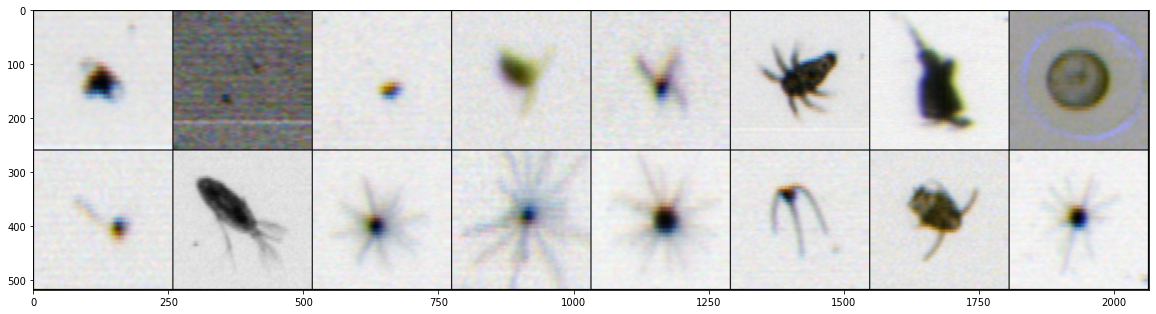

In [12]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
#     mean = np.array([0.485, 0.456, 0.406])
#     std = np.array([0.229, 0.224, 0.225])
#     inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
#     if title is not None:
#         plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

plt.figure(figsize=(20, 20))
imshow(out, title=[dataset.classes[x] for x in classes])

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [14]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [15]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}/{}'.format(class_names[preds[j]],class_names[labels[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [16]:
model_ft = torchvision.models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features

model_ft.fc = torch.nn.Linear(num_ftrs, 39)

# model_ft.fc = torch.nn.Sequential(
#     torch.nn.Linear(num_ftrs, 512),
#     torch.nn.ReLU(),
#     torch.nn.Linear(512,39)
# ) 

model_ft = model_ft.to(device)

criterion = torch.nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = torch.optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [17]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.9387 Acc: 0.7185
val Loss: 0.3901 Acc: 0.8776

Epoch 1/24
----------
train Loss: 0.5307 Acc: 0.8253
val Loss: 0.3319 Acc: 0.8933

Epoch 2/24
----------
train Loss: 0.4286 Acc: 0.8561
val Loss: 0.3039 Acc: 0.9031

Epoch 3/24
----------
train Loss: 0.3654 Acc: 0.8765
val Loss: 0.3012 Acc: 0.9060

Epoch 4/24
----------
train Loss: 0.3098 Acc: 0.8953
val Loss: 0.3074 Acc: 0.9036

Epoch 5/24
----------
train Loss: 0.2693 Acc: 0.9095
val Loss: 0.3107 Acc: 0.9066

Epoch 6/24
----------
train Loss: 0.2428 Acc: 0.9176
val Loss: 0.3186 Acc: 0.9067

Epoch 7/24
----------
train Loss: 0.1507 Acc: 0.9516
val Loss: 0.2710 Acc: 0.9214

Epoch 8/24
----------
train Loss: 0.1279 Acc: 0.9602
val Loss: 0.2780 Acc: 0.9211

Epoch 9/24
----------
train Loss: 0.1076 Acc: 0.9667
val Loss: 0.2834 Acc: 0.9234

Epoch 10/24
----------
train Loss: 0.0950 Acc: 0.9714
val Loss: 0.2934 Acc: 0.9212

Epoch 11/24
----------
train Loss: 0.0830 Acc: 0.9762
val Loss: 0.2918 Acc: 0.9216

Ep

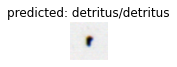

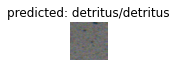

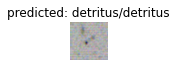

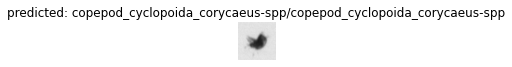

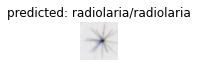

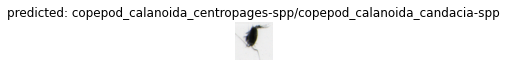

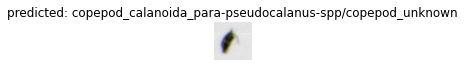

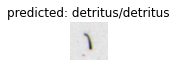

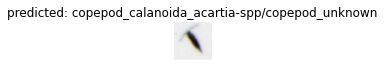

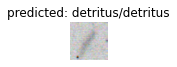

In [18]:
visualize_model(model_ft,10)

In [19]:
def evaluate(model,dataloader,dataset_size):
    since = time.time()
    
    model.eval()
    
    running_loss = 0.0
    running_corrects = 0

    # Iterate over data.
    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # forward
        # track history if only in train
        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    test_loss = running_loss / dataset_size
    test_acc = running_corrects.double() / dataset_size

    print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Test Loss: {:.4f} Acc: {:.4f}'.format(
         test_loss, test_acc))


In [20]:
evaluate(model_ft, dataloaders['test'], dataset_sizes['test'])


Training complete in 0m 10s
Test Loss: 0.3027 Acc: 0.9244


In [21]:
nb_classes = 39

confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders['test']):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix.double())

tensor([[ 11.,   0.,   0.,  ...,   0.,   0.,   0.],
        [  0.,  31.,   0.,  ...,   0.,   0.,   0.],
        [  0.,   0.,  17.,  ...,   0.,   0.,   0.],
        ...,
        [  0.,   0.,   0.,  ..., 180.,   0.,   0.],
        [  0.,   0.,   0.,  ...,   0.,  12.,   0.],
        [  0.,   0.,   0.,  ...,   0.,   0.,  29.]], dtype=torch.float64)


In [22]:
torch.set_printoptions(sci_mode=False)
class_acc = torch.diagonal(confusion_matrix)/torch.sum(confusion_matrix, dim = 1)
dict(zip(class_names, class_acc))

{'annelida_polychaeta': tensor(0.7857),
 'appendicularia': tensor(1.),
 'bivalvia-larvae': tensor(1.),
 'byrozoa-larvae': tensor(0.7778),
 'chaetognatha': tensor(0.8000),
 'cirripedia_barnacle-nauplii': tensor(1.),
 'cladocera': tensor(1.),
 'cladocera_evadne-spp': tensor(1.),
 'cnidaria': tensor(1.),
 'copepod_calanoida': tensor(0.4699),
 'copepod_calanoida_acartia-spp': tensor(0.6000),
 'copepod_calanoida_calanus-spp': tensor(0.8529),
 'copepod_calanoida_candacia-spp': tensor(0.7500),
 'copepod_calanoida_centropages-spp': tensor(0.7922),
 'copepod_calanoida_para-pseudocalanus-spp': tensor(0.7475),
 'copepod_calanoida_temora-spp': tensor(0.6875),
 'copepod_cyclopoida': tensor(0.1000),
 'copepod_cyclopoida_corycaeus-spp': tensor(0.9099),
 'copepod_cyclopoida_oithona-spp': tensor(0.5918),
 'copepod_cyclopoida_oncaea-spp': tensor(0.6479),
 'copepod_harpacticoida': tensor(0.6562),
 'copepod_nauplii': tensor(0.8768),
 'copepod_unknown': tensor(0.3946),
 'decapoda-larvae_brachyura': tensor(

In [23]:
import seaborn as sn
import pandas as pd

In [24]:
df_cm = pd.DataFrame(confusion_matrix.numpy().astype(np.int32), index = [i for i in class_names],
                  columns = [i for i in class_names])
# plt.figure(figsize = (15,15))
# sn.set(font_scale=1.4) # for label size
# sn.heatmap(df_cm, annot=True, annot_kws={"size": 8},fmt='g') # font size



In [25]:
torch.save(model_ft.state_dict(), "./models/resnet50_label3_006.pth")

In [26]:
dframe = pd.read_csv('/data/test.csv')

In [27]:
dframe.groupby(['label3']).size()

label3
annelida_polychaeta                           14
appendicularia                                31
bivalvia-larvae                               17
byrozoa-larvae                                 9
chaetognatha                                  15
cirripedia_barnacle-nauplii                   30
cladocera                                     14
cladocera_evadne-spp                          12
cnidaria                                      25
copepod_calanoida                            166
copepod_calanoida_acartia-spp                 45
copepod_calanoida_calanus-spp                 34
copepod_calanoida_candacia-spp                 4
copepod_calanoida_centropages-spp             77
copepod_calanoida_para-pseudocalanus-spp     198
copepod_calanoida_temora-spp                  16
copepod_cyclopoida                            10
copepod_cyclopoida_corycaeus-spp             111
copepod_cyclopoida_oithona-spp                49
copepod_cyclopoida_oncaea-spp                 71
copepod_harpa